In [1]:
import feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Train0 = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/Train0.feather")
Train1 = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/Train1.feather")
Test2  = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/Test2.feather")
Test1  = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/Test1.feather")




# Tentative I

Voir si ca marche en "all"
Rafinner en loc = SM
Rafinner en enlevant des freq
Add gait avec un train test split approprié aux multi-channel

Idea from : https://colab.research.google.com/drive/1smOkMgJIouKNBCZQUcmpTYrhpX2ciTHv?usp=sharing#scrollTo=tCXlxNzC7GVU

In [35]:
import tensorflow as tf

AddGait = True
# Test2.columns
if AddGait :
    Test2_local = Test2
    Test1_local = Test1
    Size3D = 52
else :
    Test2_local = Test2.drop(columns=["index", 't_APA', 'APA_antpost', 'APA_lateral', 'StepWidth', 't_swing1', 't_DA', 't_swing2', 'Longueur_pas', 'V_swing1', 'Vy_FO1', 'Vm', 't_Vm', 'VML_absolue', 'Cadence', 'VZmin_APA', 'V2', 'Diff_V'])
    Test1_local = Test1.drop(columns=["index", 't_APA', 'APA_antpost', 'APA_lateral', 'StepWidth', 't_swing1', 't_DA', 't_swing2', 'Longueur_pas', 'V_swing1', 'Vy_FO1', 'Vm', 't_Vm', 'VML_absolue', 'Cadence', 'VZmin_APA', 'V2', 'Diff_V'])
    Size3D = 34

Nd2 = Test2_local.sort_values(by='Freq').drop(columns=["Loc", "Protocol", "Condition", "GoNogo","TrialNum", "Meta_FOG", "Channel", "Freq", "Side_firststep", "Subject", "Side_channel", "Side_firststep_ipsi_contra"]).to_numpy().reshape(-1,100,Size3D) 
Nd1 = Test1_local.sort_values(by='Freq').drop(columns=["Loc", "Protocol", "Condition", "GoNogo","TrialNum", "Meta_FOG", "Channel", "Freq", "Side_firststep", "Subject", "Side_channel", "Side_firststep_ipsi_contra"]).to_numpy().reshape(-1,100,Size3D)

y_2  = np.repeat(1, Nd2.shape[0])
y_1  = np.repeat(0, Nd1.shape[0])
Nd2.shape, Nd1.shape, y_2.shape, y_1.shape


((815, 100, 52), (817, 100, 52), (815,), (817,))

In [36]:
# Train Test Split of Nd1 and Nd2
if AddGait :
    TrialList  = np.unique(Nd2[:,:,34].flatten())
    rndm_split = np.random.rand(len(TrialList))
    rndm_split = rndm_split < np.percentile(rndm_split, 80)
    TrainList  = TrialList[rndm_split]
    TestList   = TrialList[~rndm_split]
    print(TrainList.shape , TestList.shape)

    X2  = Nd2[np.isin(Nd2[:,:,34], TrainList)[:,0],:,:]
    X2t = Nd2[np.isin(Nd2[:,:,34], TestList)[:,0], :,:]
    y2  = np.repeat(1, X2.shape[0])
    y2t = np.repeat(1, X2t.shape[0])

    TrialList  = np.unique(Nd1[:,:,34].flatten())
    rndm_split = np.random.rand(len(TrialList))
    rndm_split = rndm_split < np.percentile(rndm_split, 80)
    TrainList  = TrialList[rndm_split]
    TestList   = TrialList[~rndm_split]
    print(TrainList.shape, TestList.shape)

    X1  = Nd1[np.isin(Nd1[:,:,34], TrainList)[:,0],:,:]
    X1t = Nd1[np.isin(Nd1[:,:,34], TestList)[:,0], :,:]
    y1  = np.repeat(0, X1.shape[0])
    y1t = np.repeat(0, X1t.shape[0])

else :
    from sklearn.model_selection import train_test_split
    X1, X1t, y1, y1t = train_test_split(Nd1, y_1, test_size=0.2, random_state=42)
    X2, X2t, y2, y2t = train_test_split(Nd2, y_2, test_size=0.2, random_state=42)

X1.shape, X1t.shape, y1.shape, y1t.shape, X2.shape, X2t.shape, y2.shape, y2t.shape

X_train = np.concatenate((X1, X2))
y_train = np.concatenate((y1, y2))
X_test  = np.concatenate((X1t, X2t))
y_test  = np.concatenate((y1t, y2t))

if AddGait :
    Size3D  = Size3D - 1
    X_train = np.delete(X_train, 34, axis=2)
    X_test  = np.delete(X_test,  34, axis=2)
    X_train = X_train.astype('float32')
    X_test  = X_test.astype('float32')


X_train.shape, y_train.shape, X_test.shape, y_test.shape

(51,) (13,)
(51,) (13,)


((1365, 100, 51), (1365,), (267, 100, 51), (267,))

In [37]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


TF_A_inp = Input((100, Size3D), name='TF_A_inp')
TF_B_inp = Input((100, Size3D), name='TF_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((100, Size3D, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(TF_A_inp)
feature_vector_B = cnn(TF_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[TF_A_inp, TF_B_inp], outputs=output)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TF_A_inp (InputLayer)          [(None, 100, 51)]    0           []                               
                                                                                                  
 TF_B_inp (InputLayer)          [(None, 100, 51)]    0           []                               
                                                                                                  
 sequential_24 (Sequential)     (None, 64)           1586496     ['TF_A_inp[0][0]',               
                                                                  'TF_B_inp[0][0]']               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 128)          0           ['sequential_24[0][0]',    

In [38]:
import platform

if platform.system() == "Windows" :
    random_indices = np.random.choice(X_train.shape[0], 300, replace=False)
    X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]
else :
    X_train_sample, y_train_sample = X_train, y_train

len(X_train_sample) ** 2

90000

In [39]:
import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]
  
  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    TF_A, label_A = t[0]
    TF_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([TF_A, TF_B])
    y_pairs.append(new_label)
  
  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)
X_train_pairs.shape, y_train_pairs.shape

((90000, 2, 100, 51), (90000,))

In [40]:
import platform

if platform.system() == "Windows" :
    random_indices = np.random.choice(X_test.shape[0], 150, replace=False)
    X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]
    X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)
else :
    X_test_pairs, y_test_pairs = make_paired_dataset(X_test, y_test)

X_test_pairs.shape, y_test_pairs.shape

((22500, 2, 100, 51), (22500,))

In [41]:
import tensorflow as tf
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [42]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :], 
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=1000,
          batch_size=32,
          callbacks=[es])

Epoch 1/1000
2813/2813 [==============================] - 885s 314ms/step - loss: nan - accuracy: 0.4968 - val_loss: nan - val_accuracy: 0.4999
Epoch 2/1000
 966/2813 [=========>....................] - ETA: 9:16 - loss: nan - accuracy: 0.4956

KeyboardInterrupt: 

# SVC
let's try an svc directly on that

In [44]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

X_train_2D = X_train.reshape(X_train.shape[0], -1)
X_test_2D  = X_test.reshape(X_test.shape[0], -1)
# create an instance of SVM and fit our data
clf = SVC()
clf.fit(X_train_2D, y_train)

# predict the test set
ypred = clf.predict(X_test_2D)

# print the accuracy score
print("Accuracy:", accuracy_score(y_test, ypred))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test_2D, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [47]:
for i in range(267) :
    for j in range(5100):
        if np.isnan(X_train_2D[i,j]) :
            print("pbm ", i, " ", j)

pbm  1   340
pbm  1   341
pbm  1   342
pbm  1   343
pbm  1   344
pbm  1   345
pbm  1   346
pbm  1   347
pbm  1   348
pbm  1   349
pbm  1   350
pbm  1   351
pbm  1   352
pbm  1   353
pbm  1   354
pbm  1   355
pbm  1   356
pbm  1   697
pbm  1   698
pbm  1   699
pbm  1   700
pbm  1   701
pbm  1   702
pbm  1   703
pbm  1   704
pbm  1   705
pbm  1   706
pbm  1   707
pbm  1   708
pbm  1   709
pbm  1   710
pbm  1   711
pbm  1   712
pbm  1   713
pbm  3   2839
pbm  3   2840
pbm  3   2841
pbm  3   2842
pbm  3   2843
pbm  3   2844
pbm  3   2845
pbm  3   2846
pbm  3   2847
pbm  3   2848
pbm  3   2849
pbm  3   2850
pbm  3   2851
pbm  3   2852
pbm  3   2853
pbm  3   2854
pbm  3   2855
pbm  3   3094
pbm  3   3095
pbm  3   3096
pbm  3   3097
pbm  3   3098
pbm  3   3099
pbm  3   3100
pbm  3   3101
pbm  3   3102
pbm  3   3103
pbm  3   3104
pbm  3   3105
pbm  3   3106
pbm  3   3107
pbm  3   3108
pbm  3   3109
pbm  3   3110
pbm  10   1921
pbm  10   1922
pbm  10   1923
pbm  10   1924
pbm  10   1925
pbm  10

## Another SVC (non working)

In [ ]:
Xtrain = pd.concat([Train0, Train1], axis=0)
Xtest  = pd.concat([Test1, Test2], axis=0)

Xtrain = Xtrain.drop(columns=["Loc", "Protocol", "Condition", "GoNogo","TrialNum", "Channel", "Side_firststep", "Subject"])
Xtest  = Xtest.drop( columns=["Loc", "Protocol", "Condition", "GoNogo","TrialNum", "Channel", "Side_firststep", "Subject"])
Xtrain = Xtrain.rename(columns={'index': 'INDEX'})
Xtest  = Xtest.rename( columns={'index': 'INDEX'})

ytrain = Xtrain["Meta_FOG"]
ytest  = Xtest["Meta_FOG"]

#Xtrain = Xtrain.drop(columns=["Meta_FOG"])
#Xtest  = Xtest.drop(columns=["Meta_FOG"])


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])


In [ ]:
XtrainLocal = Xtrain[(Xtrain['Freq'] >= 12) & (Xtrain['Freq'] <= 35)]
XtestLocal  = Xtest [(Xtest['Freq']  >= 12) & (Xtest['Freq']  <= 35)]
ytrainLocal = XtrainLocal["Meta_FOG"]
ytestLocal  = XtestLocal[ "Meta_FOG"]
XtrainLocal = XtrainLocal.drop(columns=["Meta_FOG"]).drop(columns=["Side_channel"]).drop(columns=["Side_firststep_ipsi_contra"])
XtestLocal  = XtestLocal.drop( columns=["Meta_FOG"]).drop(columns=["Side_channel"]).drop(columns=["Side_firststep_ipsi_contra"])
XtrainLocal.groupby(['INDEX']).mean()
XtestLocal.groupby(['INDEX']).mean()

#ytestLocal[ytestLocal == 2] = 0


# create an instance of SVM and fit our data
clf = SVC()
clf.fit(Xtrain, ytrain)

# predict the test set
ypred = clf.predict(Xtest)

# print the accuracy score
#print("Accuracy:", accuracy_score(ytest, ypred))

# plot the confusion matrix
#disp = ConfusionMatrixDisplay.from_estimator(clf, Xtest, ytest, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all')

# New version

## Desjo

In [2]:
import feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.neighbors import KNeighborsClassifier

DEj_stat_SM_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_stat_SM_diff_channel.feather")
DEj_stat_AS_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_stat_AS_diff_channel.feather")
DEj_stat_all_diff_channel= feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_stat_all_diff_channel.feather")
DEj_stat_SM_meanCh       = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_stat_SM_meanCh.feather")
DEj_stat_AS_meanCh       = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_stat_AS_meanCh.feather")

Accuracy SVM: 0.6666666666666666
Accuracy KNN: 0.8333333333333334


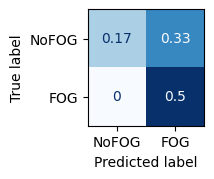

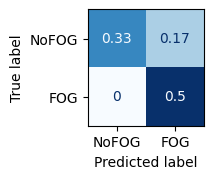

In [3]:
# Consignes
DropMissing = True
dataframe = DEj_stat_SM_diff_channel
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.8333333333333334
Accuracy KNN: 0.6666666666666666


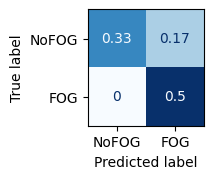

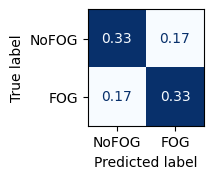

In [4]:
# Consignes
DropMissing = True
dataframe = DEj_stat_AS_diff_channel
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.6666666666666666
Accuracy KNN: 0.8333333333333334


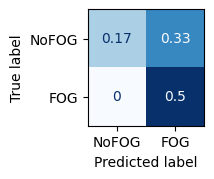

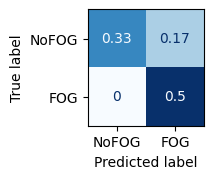

In [5]:
# Consignes
DropMissing = True
dataframe = DEj_stat_all_diff_channel
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.7777777777777778
Accuracy KNN: 0.8888888888888888


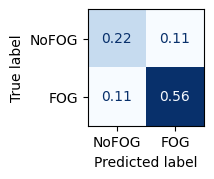

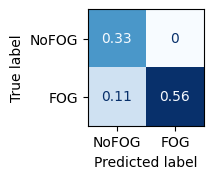

In [6]:
# Consignes
DropMissing = True
dataframe = DEj_stat_SM_meanCh
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.0
Accuracy KNN: 0.0


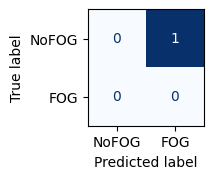

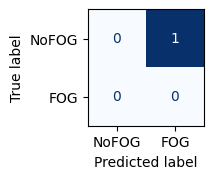

In [7]:
# Consignes
DropMissing = True
dataframe = DEj_stat_AS_meanCh
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.5714285714285714
Accuracy KNN: 0.8571428571428571


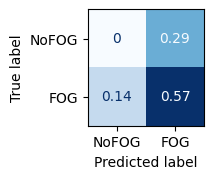

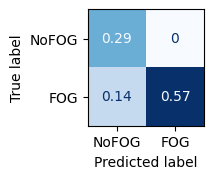

In [8]:
# Consignes
DropMissing = True
dataframe = DEj_stat_SM_meanCh
columns_to_drop = ["index", "Meta_FOG", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.6666666666666666
Accuracy KNN: 0.8333333333333334


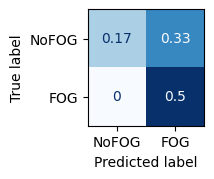

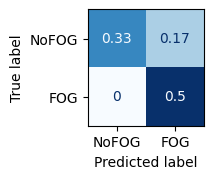

In [9]:
# Consignes
DropMissing = True
dataframe = DEj_stat_SM_diff_channel
columns_to_drop = ["index", "Meta_FOG", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.5714285714285714
Accuracy KNN: 0.5714285714285714


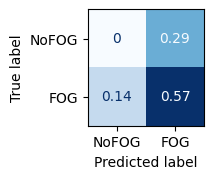

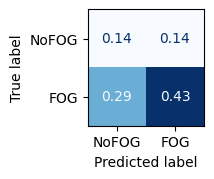

In [10]:
# Consignes
DropMissing = True
dataframe = DEj_stat_SM_meanCh
columns_to_drop = ["index", "Meta_FOG", "Diff_V", "Power"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

### Beta Band

In [11]:
DEj_beta_SM_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_beta_SM_diff_channel.feather")
DEj_beta_SM_meanCh       = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_beta_SM_meanCh.feather")
DEj_lowbeta_SM_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_lowbeta_SM_diff_channel.feather")
DEj_lowbeta_SM_meanCh       = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_lowbeta_SM_meanCh.feather")
DEj_highbeta_SM_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_highbeta_SM_diff_channel.feather")
DEj_highbeta_SM_meanCh       = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_highbeta_SM_meanCh.feather")

Accuracy SVM: 1.0
Accuracy KNN: 0.8571428571428571


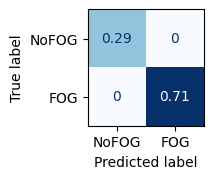

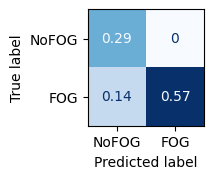

In [12]:
# Consignes
DropMissing = True
dataframe = DEj_beta_SM_meanCh
columns_to_drop = ["index", "Meta_FOG", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.8571428571428571
Accuracy KNN: 0.8571428571428571


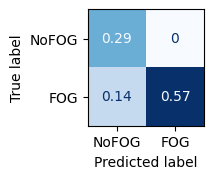

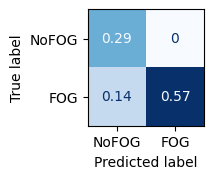

In [13]:
# Consignes
DropMissing = True
dataframe = DEj_lowbeta_SM_meanCh
columns_to_drop = ["index", "Meta_FOG", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.8571428571428571
Accuracy KNN: 0.7142857142857143


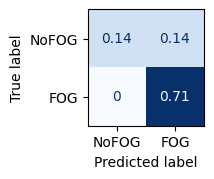

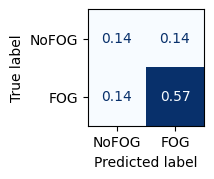

In [14]:
# Consignes
DropMissing = True
dataframe = DEj_highbeta_SM_meanCh
columns_to_drop = ["index", "Meta_FOG", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.6666666666666666
Accuracy KNN: 0.6666666666666666


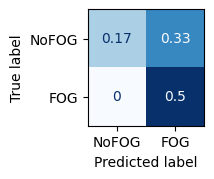

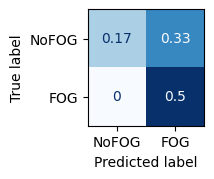

In [15]:
# Consignes
DropMissing = True
dataframe = DEj_beta_SM_diff_channel
columns_to_drop = ["index", "Meta_FOG", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

## All Patients

In [16]:
import feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

AllPat_stat_SM_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_stat_SM_diff_channel.feather")
AllPat_stat_AS_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_stat_AS_diff_channel.feather")
AllPat_stat_all_diff_channel= feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_stat_all_diff_channel.feather")
AllPat_stat_SM_meanCh       = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_stat_SM_meanCh.feather")
AllPat_stat_AS_meanCh       = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_stat_AS_meanCh.feather")
AllPat_beta_SM_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_beta_SM_meanCh.feather")
#AllPat_beta_AS_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_beta_AS_meanCh.feather")
AllPat_lowbeta_SM_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_lowbeta_SM_meanCh.feather")
#AllPat_lowbeta_AS_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_lowbeta_AS_meanCh.feather")
AllPat_highbeta_SM_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_highbeta_SM_meanCh.feather")
#AllPat_highbeta_AS_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_highbeta_AS_meanCh.feather")
AllPat_bothbeta_SM_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_bothbeta_SM_meanCh.feather")
AllPat_bothbeta_all_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_bothbeta_all_meanCh.feather")
AllPat_stat_all_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/AllPat_stat_all_meanCh.feather")

from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')

print("Le drop Missing est manquant")

Le drop Missing est manquant


Accuracy SVM: 0.5
Accuracy KNN: 0.5555555555555556


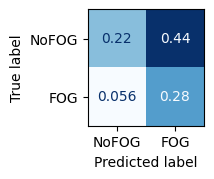

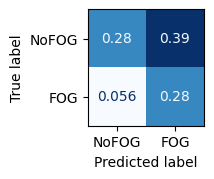

In [17]:
# Consignes
DropMissing = True
dataframe = AllPat_stat_SM_meanCh
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X
X, y = under.fit_resample(X, y)
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 0.7407407407407407
Accuracy KNN: 0.7037037037037037


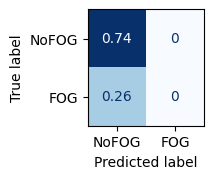

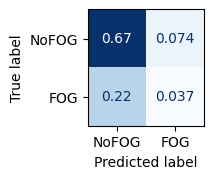

In [18]:
# Consignes
DropMissing = True
dataframe = AllPat_stat_AS_meanCh
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Accuracy SVM: 1.0
Accuracy KNN: 1.0


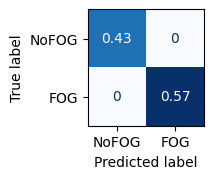

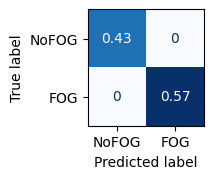

In [19]:
# Consignes
DropMissing = True
dataframe = AllPat_stat_SM_diff_channel
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

### Beta Band

Accuracy SVM: 0.6333333333333333
Accuracy KNN: 0.6


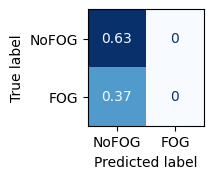

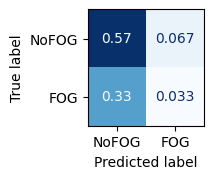

In [20]:
# Consignes
DropMissing = True
dataframe = AllPat_highbeta_SM_meanCh
columns_to_drop = ["index", "Meta_FOG"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X
    
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

Clani

In [21]:
CLn_bothbeta_AS_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_bothbeta_AS_meanCh.feather")
CLn_emm_AS_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_emm_AS_diff_channel.feather")

CLn_stat_AS_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_stat_AS_diff_channel.feather")
CLn_stat_all_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_stat_all_diff_channel.feather")
CLn_stat_AS_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_stat_AS_meanCh.feather")
CLn_stat_all_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_stat_all_meanCh.feather")

CLn_beta_AS_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_beta_AS_diff_channel.feather")
CLn_lowbeta_AS_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_lowbeta_AS_diff_channel.feather")
CLn_highbeta_AS_diff_channel = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_highbeta_AS_diff_channel.feather")
CLn_beta_AS_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_beta_AS_meanCh.feather")
CLn_lowbeta_AS_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_lowbeta_AS_meanCh.feather")
CLn_highbeta_AS_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/CLn_highbeta_AS_meanCh.feather")

from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy="auto")

Accuracy SVM: 0.3333333333333333
Accuracy KNN: 0.6666666666666666
Accuracy SVM: 0.3333333333333333
Accuracy KNN: 0.6666666666666666


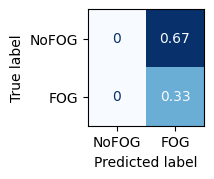

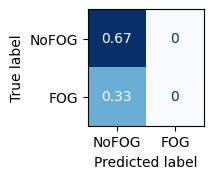

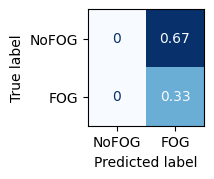

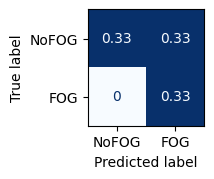

In [22]:
# Consignes
DropMissing = True
dataframe1 = CLn_bothbeta_AS_meanCh
dataframe2 = CLn_emm_AS_diff_channel
columns_to_drop = ["index", "Diff_V", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2"]

# 1 DiffCh
dataframe = dataframe1.drop(columns=columns_to_drop)
dataframe = dataframe.dropna(axis=0) if DropMissing else dataframe
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=["Meta_FOG"])
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X
X, y = under.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# 2 MeanCh
dataframe = dataframe2.drop(columns=columns_to_drop)
dataframe = dataframe.dropna(axis=0) if DropMissing else dataframe
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=["Meta_FOG"])
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X
X, y = under.fit_resample(X, y)
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

## Re DESJO Bien

Accuracy SVM: 0.8571428571428571
Accuracy KNN: 1.0


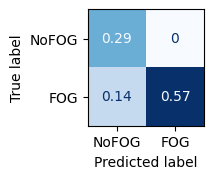

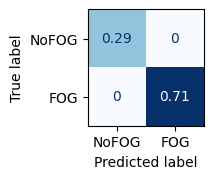

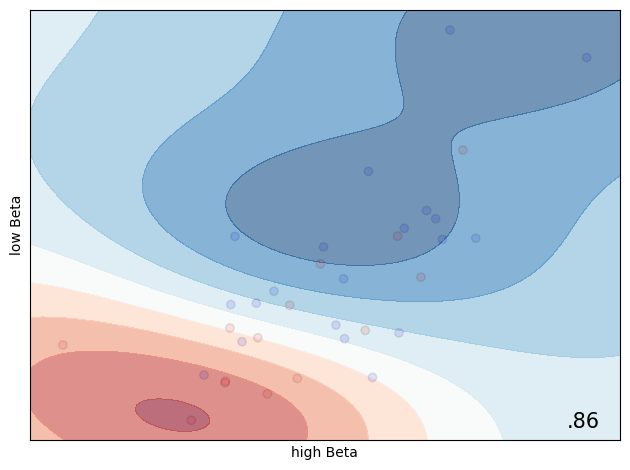

In [23]:
# Consignes
DropMissing = True
DEj_bothbeta_SM_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_bothbeta_SM_meanCh.feather")
DEj_stat_all_meanCh = feather.read_dataframe("C:/LustreSync/LAU Brian - 2024_GBMOV/Data/AI/dataset/DEj_stat_all_meanCh.feather")
dataframe = DEj_bothbeta_SM_meanCh
columns_to_drop = ["index", "Meta_FOG", "Diff_V", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2"]

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

if DropMissing :
    dataframe = dataframe.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

X = dataframe.drop(columns=columns_to_drop)
score = accuracy_score(y_test, clf.predict(X_test))
figure = plt.figure()
x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
ax = plt.subplot(1, 1, 1)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.6, ax=ax, eps=0.5)
y_color = np.array(['#0000FF' if i == "2" else '#FF0000' for i in y])

ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_color, edgecolors="k", alpha=0.1)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right", )

plt.tight_layout()
plt.show()

Accuracy SVM: 0.8571428571428571
Accuracy KNN: 0.8571428571428571
Accuracy SVM: 0.8571428571428571
Accuracy KNN: 0.8571428571428571


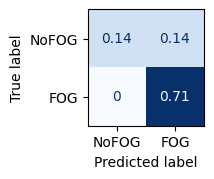

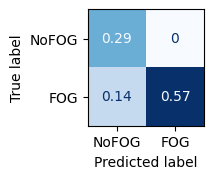

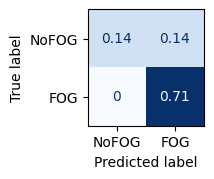

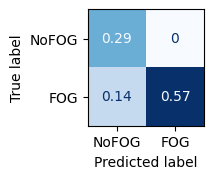

In [24]:
# Consignes
DropMissing = True
dataframe1 = DEj_stat_SM_meanCh
dataframe2 = DEj_stat_all_meanCh
columns_to_drop = ["index", "Meta_FOG", "Diff_V", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2"]

# 1 DiffCh
if DropMissing :
    dataframe = dataframe1.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# 2 MeanCh
if DropMissing :
    dataframe = dataframe2.dropna(axis=0)
y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X
# SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

## Use DESJo as train and all others as test sets


Accuracy SVM: 0.5454545454545454
Accuracy KNN: 0.6898395721925134


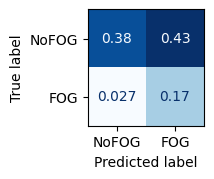

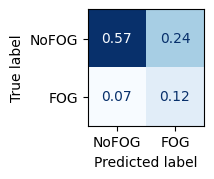

In [25]:
# Consignes
DropMissing = True
dataframeTrain = DEj_stat_all_meanCh
dataframeTest  = AllPat_stat_all_meanCh
dataframeTest  = dataframeTest[~dataframeTest["index"].str.contains("DEj")]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

# Préparation des données
if DropMissing :
    dataframeTest  = dataframeTest.dropna(axis=0)
    dataframeTrain = dataframeTrain.dropna(axis=0)
y_train, X_train = dataframeTrain["Meta_FOG"], dataframeTrain.drop(columns=columns_to_drop).to_numpy()
y_test,  X_test  = dataframeTest["Meta_FOG"],  dataframeTest.drop(columns=columns_to_drop).to_numpy()
    
# SVC
clf = SVC().fit(X_train, y_train)
print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

## V2.1 : kfold and more

In [26]:
def ClassifIntra(dataframe, columns_to_drop, DropMissing=True, kfolds=200, Verbose=False, KFoldPlot=True, title = ""):
    if DropMissing :
        dataframe = dataframe.dropna(axis=0)
    y, X = dataframe["Meta_FOG"], dataframe.drop(columns=columns_to_drop)
    X = X.to_numpy() if not isinstance(X, (np.ndarray)) else X

    Accuracy_SVM, Accuracy_KNN, F1_SVM, F1_KNN = [], [], [], []
    for i in range(kfolds):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        clf = SVC().fit(X_train, y_train)
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        Accuracy_SVM.append(accuracy_score(y_test, clf.predict(X_test)))
        Accuracy_KNN.append(accuracy_score(y_test, knn.predict(X_test)))
        F1_SVM.append(f1_score(y_test, clf.predict(X_test), pos_label="2"))
        F1_KNN.append(f1_score(y_test, knn.predict(X_test), pos_label="2"))
        if Verbose :
            print("Accuracy SVM:", accuracy_score(y_test, clf.predict(X_test)))
            disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
            disp.plot()
            print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))
            disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
            disp.plot()

    if KFoldPlot :
        # boxplot
        fig, ax = plt.subplots()
        ax.boxplot([Accuracy_SVM, F1_SVM, Accuracy_KNN, F1_KNN], showfliers=True, patch_artist=True)        
        ax.set_xticklabels(["Acc. SVM", "F1 SVM", "Acc. KNN", "F1 KNN"])
        ax.text(1, np.mean(Accuracy_SVM), f"{np.mean(Accuracy_SVM):.2f}", ha='center', va='center', color='black', fontsize=10)
        ax.text(2, np.mean(F1_SVM), f"{np.mean(F1_SVM):.2f}", ha='center', va='center', color='black', fontsize=10)
        ax.text(3, np.mean(Accuracy_KNN), f"{np.mean(Accuracy_KNN):.2f}", ha='center', va='center', color='black', fontsize=10)
        ax.text(4, np.mean(F1_KNN), f"{np.mean(F1_KNN):.2f}", ha='center', va='center', color='black', fontsize=10)
        ax.text(1.5, 0.9, f"KFold: {kfolds}", ha='center', va='center', color='black', fontsize=10)
        fig.set_figwidth(4)
        fig.set_figheight(3.5)
        if title != "":
            plt.title(title)
        plt.show()
    return Accuracy_SVM, Accuracy_KNN, F1_SVM, F1_KNN

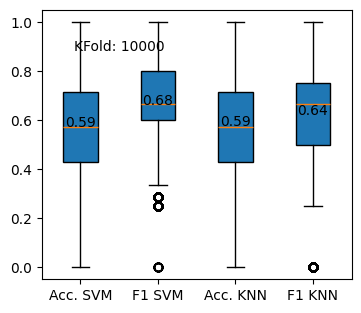

In [27]:
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]
Acc_SVM, Acc_KNN, F1_SVM, F1_KNN = ClassifIntra(DEj_stat_all_meanCh, columns_to_drop, kfolds=10000)

In [28]:
def ClassifMulti(dataframeTrain,dataframeTest, columns_to_drop, PatientRef, DropMissing=True, Verbose=True):
    dataframeTest  = dataframeTest[~dataframeTest["index"].str.contains(PatientRef)]
    if DropMissing :
        dataframeTest  = dataframeTest.dropna(axis=0)
        dataframeTrain = dataframeTrain.dropna(axis=0)
    y_train, X_train = dataframeTrain["Meta_FOG"], dataframeTrain.drop(columns=columns_to_drop).to_numpy()
    y_test,  X_test  = dataframeTest["Meta_FOG"],  dataframeTest.drop(columns=columns_to_drop).to_numpy()

    clf = SVC().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    Accuracy_SVM = (accuracy_score(y_test, clf.predict(X_test)))
    Accuracy_KNN = (accuracy_score(y_test, knn.predict(X_test)))
    F1_SVM = (f1_score(y_test, clf.predict(X_test), pos_label="2"))
    F1_KNN = (f1_score(y_test, knn.predict(X_test), pos_label="2"))
    if Verbose :
        print("Accuracy SVM:", f"{Accuracy_SVM:.2f}", "- F1 SVM:", f"{F1_SVM:.2f}", " //  Acc. KNN:", f"{Accuracy_KNN:.2f}", "- F1 KNN:", f"{F1_KNN:.2f}")
        disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
        disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)

    return Accuracy_SVM, Accuracy_KNN, F1_SVM, F1_KNN

Accuracy SVM: 0.55 - F1 SVM: 0.42  //  Acc. KNN: 0.69 - F1 KNN: 0.44


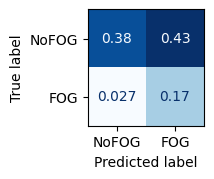

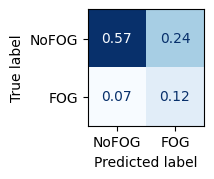

In [29]:
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]

Acc_SVM, Acc_KNN, F1_SVM, F1_KNN = ClassifMulti(DEj_stat_all_meanCh, AllPat_stat_all_meanCh, columns_to_drop, PatientRef = "DEj")

In [30]:
def ClassifPerPat(dataframeTrain,dataframeTest, columns_to_drop, PatientRef, title = "", DropMissing=True, Verbose=False, GlobalFig=True, knn_var = 3):
    dataframeTest  = dataframeTest[~dataframeTest["index"].str.contains(PatientRef)]
    dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]
    if DropMissing :
        dataframeTest  = dataframeTest.dropna(axis=0)
        dataframeTrain = dataframeTrain.dropna(axis=0)
    y_train, X_train = dataframeTrain["Meta_FOG"], dataframeTrain.drop(columns=columns_to_drop).to_numpy()
    y_test_g,  X_test_g  = dataframeTest["Meta_FOG"],  dataframeTest.drop(columns=columns_to_drop).drop(columns=["Patient"]).to_numpy()
    Accuracy_SVM, Accuracy_KNN, F1_SVM, F1_KNN, PatList = [], [], [], [], []
    clf = SVC().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
    GblAccSVM = (accuracy_score(y_test_g, clf.predict(X_test_g)))
    GblAccKNN = (accuracy_score(y_test_g, knn.predict(X_test_g)))
    for Patient in dataframeTest["Patient"].unique():
        dataframeTest_Patient = dataframeTest[dataframeTest["Patient"] == Patient]
        columns_to_drop = columns_to_drop + ["Patient"]
        y_test,  X_test  = dataframeTest_Patient["Meta_FOG"],  dataframeTest_Patient.drop(columns=columns_to_drop).to_numpy()
        clf = SVC().fit(X_train, y_train)
        knn = KNeighborsClassifier(n_neighbors=knn_var)
        knn.fit(X_train, y_train)
        Accuracy_SVM.append(accuracy_score(y_test, clf.predict(X_test)))
        Accuracy_KNN.append(accuracy_score(y_test, knn.predict(X_test)))
        F1_SVM.append(f1_score(y_test, clf.predict(X_test), pos_label="2"))
        F1_KNN.append(f1_score(y_test, knn.predict(X_test), pos_label="2"))
        PatList.append(Patient)
        if Verbose :
            disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
            disp = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
    if GlobalFig:
        fig, ax = plt.subplots()
        ax.plot(PatList, Accuracy_SVM, color='b', label='Accuracy SVM')
        ax.plot(PatList, Accuracy_KNN, color='r', label='Accuracy KNN')
        ax.plot(PatList, F1_SVM, color='cyan', label='F1 SVM',linestyle='--')
        ax.plot(PatList, F1_KNN, color='magenta', label='F1 KNN', linestyle='--')
        ax.set_ylabel('Accuracy by Patient')
        ax.text(6, 0.1, f"Global Acc. KNN: {GblAccKNN:.2f}", ha='center', va='center', color='black', fontsize=10)
        ax.text(6, 0.2, f"Global Acc. SVM: {GblAccSVM:.2f}", ha='center', va='center', color='black', fontsize=10)
        ax.set_title(title)
        ax.legend()
        fig.set_figwidth(7)
        fig.set_figheight(4)
        plt.show()
    return Accuracy_SVM, Accuracy_KNN, F1_SVM, F1_KNN

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


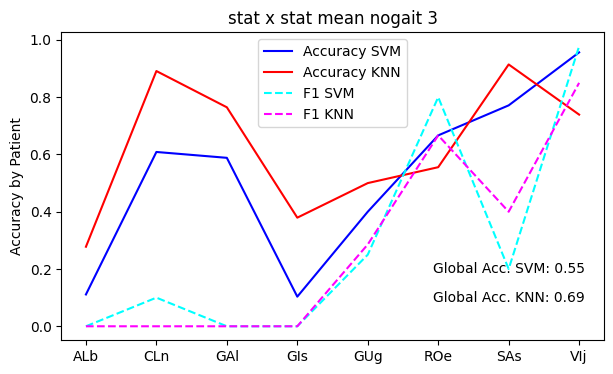

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


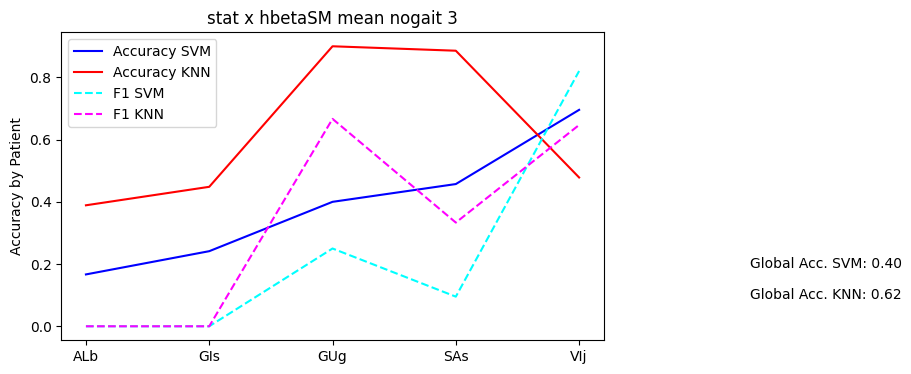

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


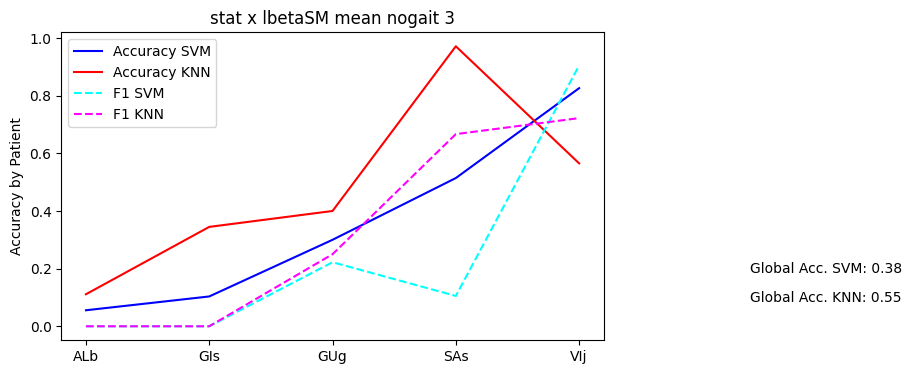

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


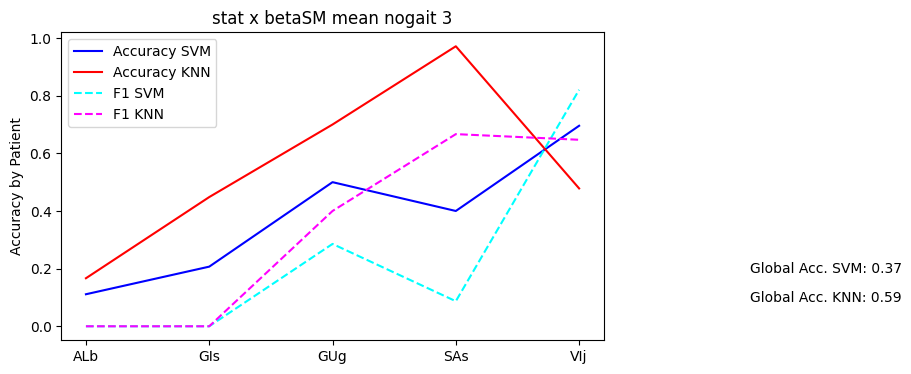

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


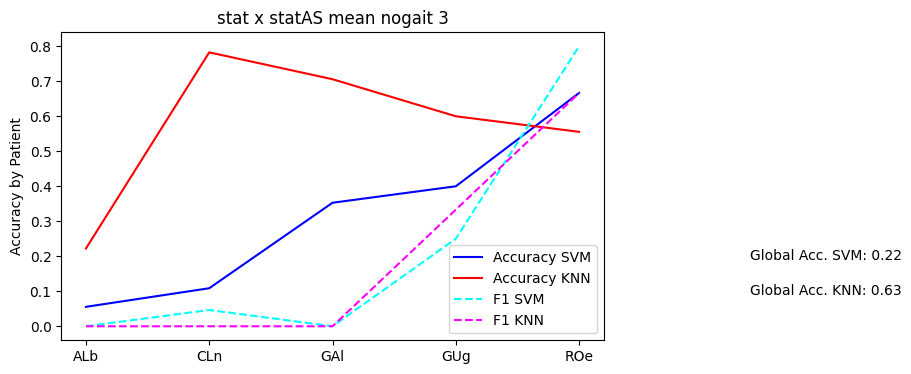

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


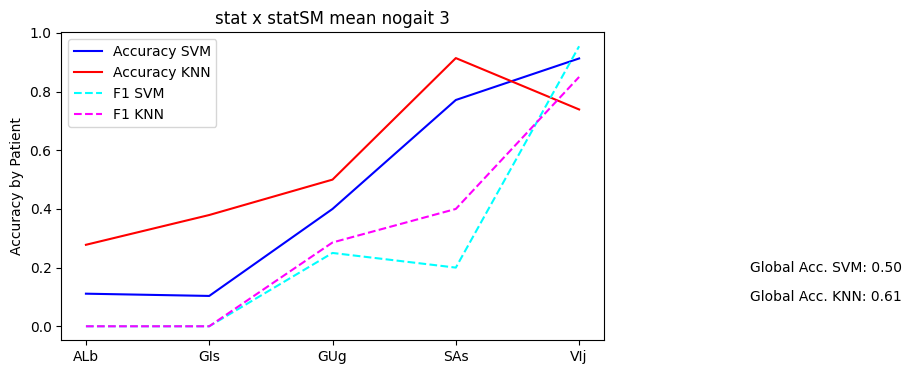

In [31]:
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_stat_all_meanCh, columns_to_drop, PatientRef="DEj", title="stat x stat mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_highbeta_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x hbetaSM mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_lowbeta_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x lbetaSM mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_beta_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x betaSM mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_stat_AS_meanCh, columns_to_drop, PatientRef="DEj", title="stat x statAS mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_stat_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x statSM mean nogait 3", knn_var=3)

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


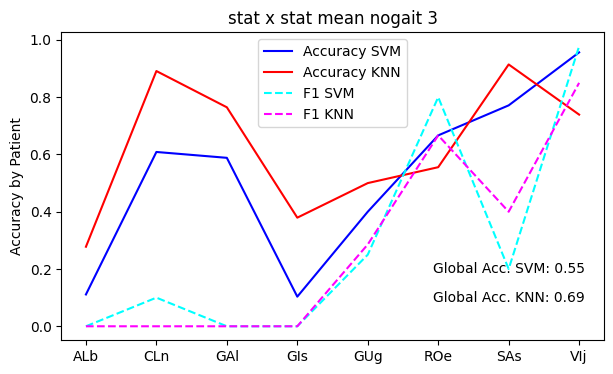

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


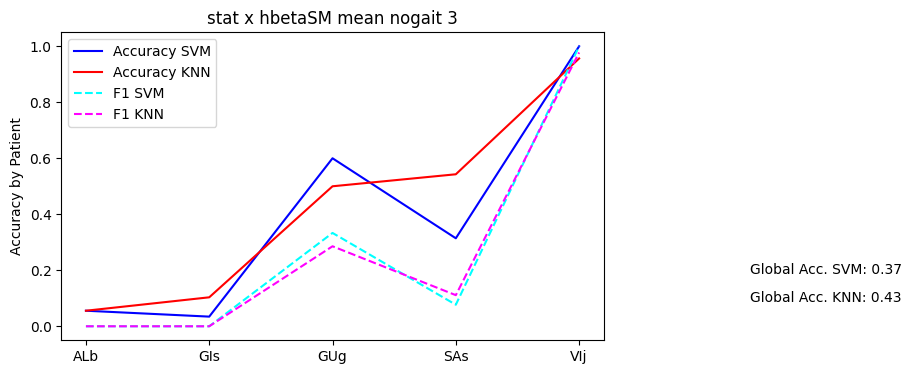

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


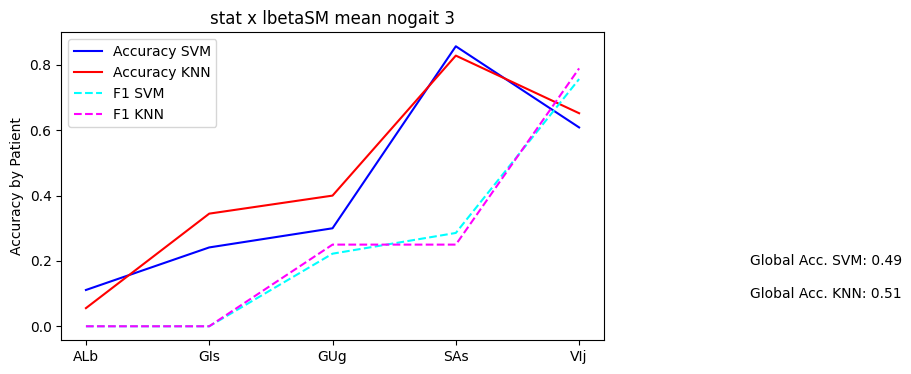

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


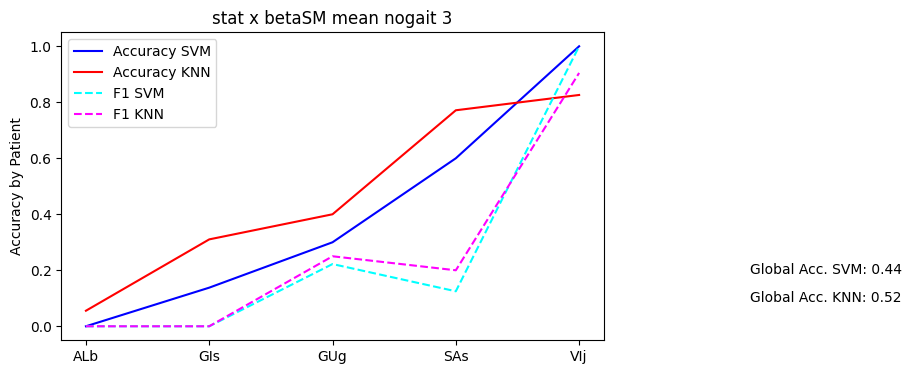

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


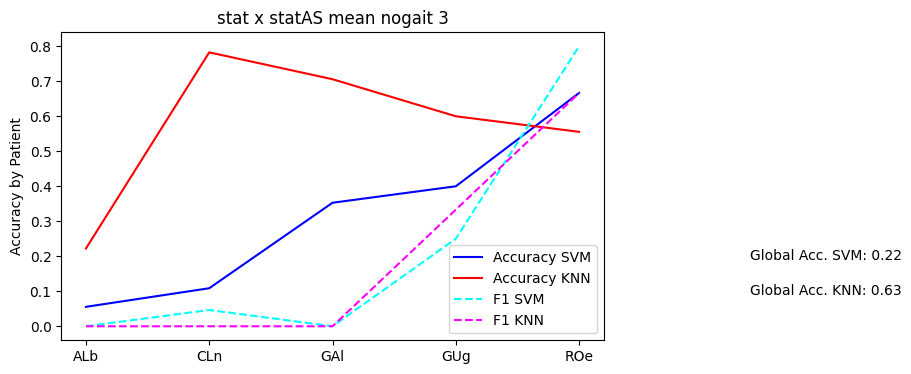

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


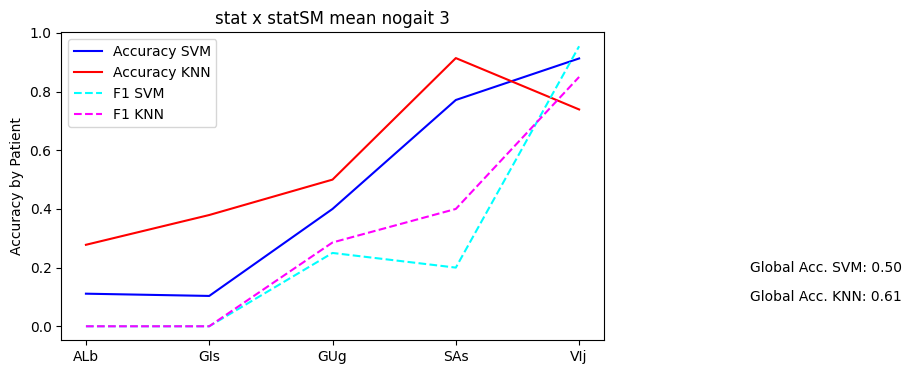

In [32]:
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_stat_all_meanCh, columns_to_drop, PatientRef="DEj", title="stat x stat mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_highbeta_SM_meanCh, AllPat_highbeta_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x hbetaSM mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_lowbeta_SM_meanCh, AllPat_lowbeta_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x lbetaSM mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_beta_SM_meanCh, AllPat_beta_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x betaSM mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_stat_AS_meanCh, columns_to_drop, PatientRef="DEj", title="stat x statAS mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_stat_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x statSM mean nogait 3", knn_var=3)

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


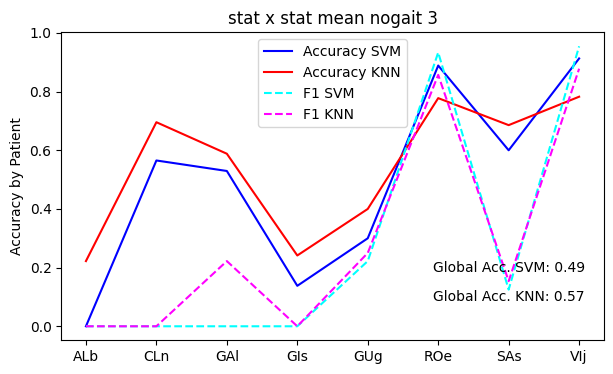

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


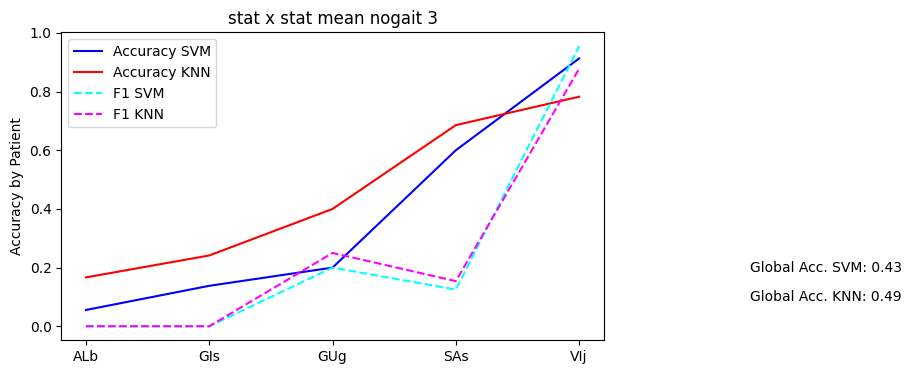

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


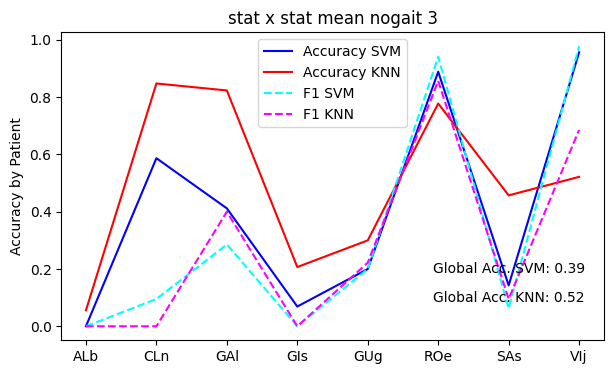

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


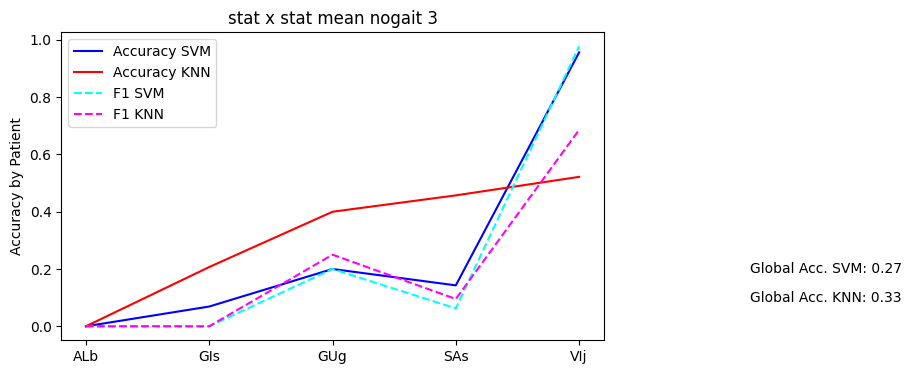

In [33]:
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]
_,_,_,_=ClassifPerPat(DEj_bothbeta_SM_meanCh, AllPat_bothbeta_all_meanCh, columns_to_drop, PatientRef="DEj", title="stat x stat mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_bothbeta_SM_meanCh, AllPat_bothbeta_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x stat mean nogait 3", knn_var=3)

columns_to_drop = ["index", "Meta_FOG"]
_,_,_,_=ClassifPerPat(DEj_bothbeta_SM_meanCh, AllPat_bothbeta_all_meanCh, columns_to_drop, PatientRef="DEj", title="stat x stat mean nogait 3", knn_var=3)
_,_,_,_=ClassifPerPat(DEj_bothbeta_SM_meanCh, AllPat_bothbeta_SM_meanCh, columns_to_drop, PatientRef="DEj", title="stat x stat mean nogait 3", knn_var=3)

C:\Users\mathieu.yeche\AppData\Local\Temp\ipykernel_71068\1037941487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeTest.loc[:, "Patient"] = dataframeTest["index"].str[:3]


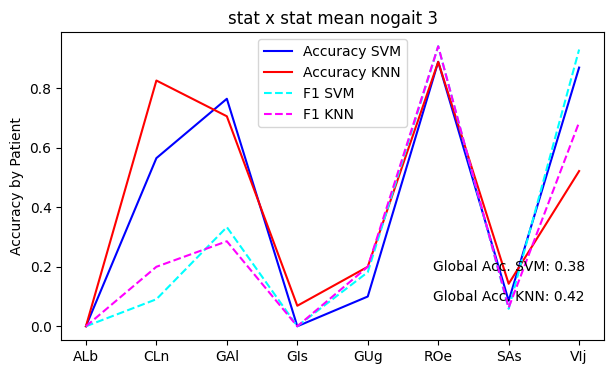

In [34]:
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_DA", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "VZmin_APA", "V2", "Diff_V"]
_,_,_,_=ClassifPerPat(DEj_stat_all_meanCh, AllPat_stat_all_meanCh, columns_to_drop, PatientRef="DEj", title="stat x stat mean nogait 3", knn_var=3)


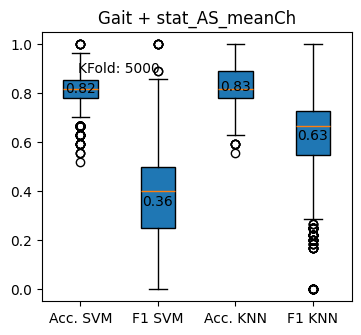

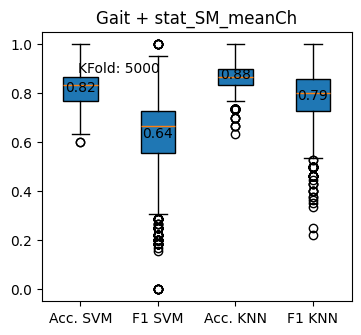

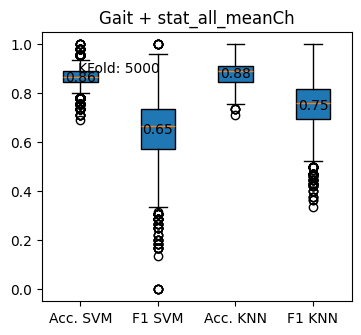

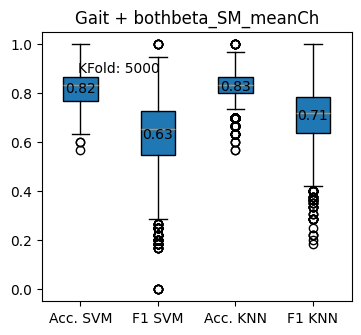

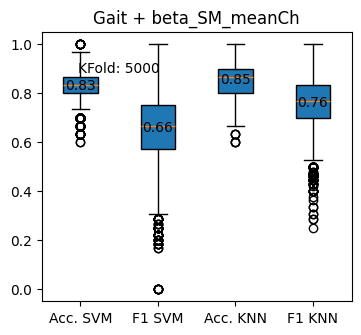

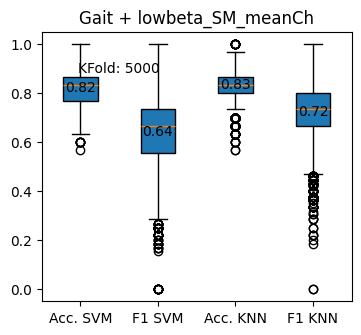

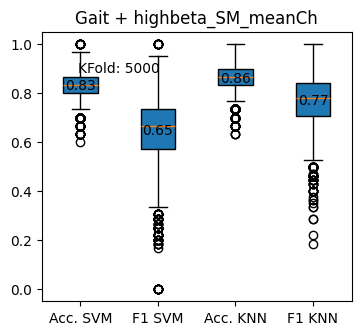

In [35]:
columns_to_drop = ["index", "Meta_FOG"]
from sklearn.metrics import f1_score 
_,_,_,_ = ClassifIntra(AllPat_stat_AS_meanCh, columns_to_drop,     kfolds=5000, title = "Gait + stat_AS_meanCh")
_,_,_,_ = ClassifIntra(AllPat_stat_SM_meanCh, columns_to_drop,     kfolds=5000, title = "Gait + stat_SM_meanCh")
_,_,_,_ = ClassifIntra(AllPat_stat_all_meanCh, columns_to_drop,    kfolds=5000, title = "Gait + stat_all_meanCh")
_,_,_,_ = ClassifIntra(AllPat_bothbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "Gait + bothbeta_SM_meanCh")
_,_,_,_ = ClassifIntra(AllPat_beta_SM_meanCh, columns_to_drop,     kfolds=5000, title = "Gait + beta_SM_meanCh")
_,_,_,_ = ClassifIntra(AllPat_lowbeta_SM_meanCh, columns_to_drop,  kfolds=5000, title = "Gait + lowbeta_SM_meanCh")
_,_,_,_ = ClassifIntra(AllPat_highbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "Gait + highbeta_SM_meanCh")


In [36]:
columns_to_drop = ["index", "Meta_FOG", "Power"]
_,_,_,_ = ClassifIntra(AllPat_stat_AS_meanCh, columns_to_drop,     kfolds=5000, title = "GAIT_AS")
_,_,_,_ = ClassifIntra(AllPat_stat_SM_meanCh, columns_to_drop,     kfolds=5000, title = "GAIT_SM")
_,_,_,_ = ClassifIntra(AllPat_stat_all_meanCh, columns_to_drop,    kfolds=5000, title = "GAIT_all")
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]
_,_,_,_ = ClassifIntra(AllPat_stat_AS_meanCh, columns_to_drop,     kfolds=5000, title = "stat_AS_meanCh")
_,_,_,_ = ClassifIntra(AllPat_stat_SM_meanCh, columns_to_drop,     kfolds=5000, title = "stat_SM_meanCh")
_,_,_,_ = ClassifIntra(AllPat_stat_all_meanCh, columns_to_drop,    kfolds=5000, title = "stat_all_meanCh")

c:\Users\mathieu.yeche\Anaconda3\envs\GTP\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


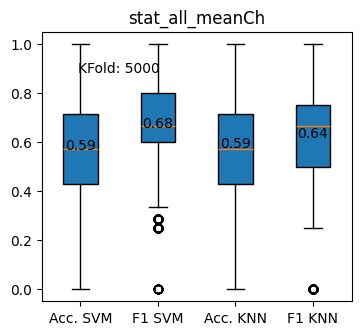

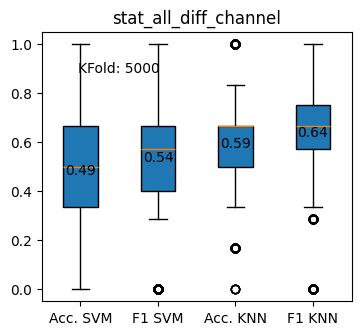

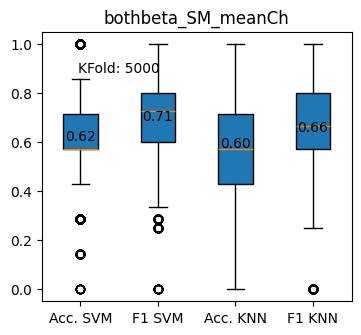

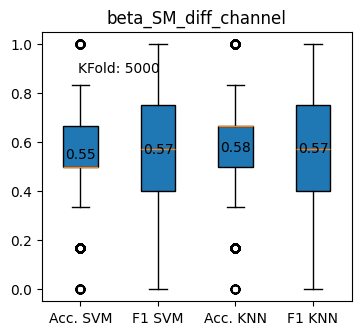

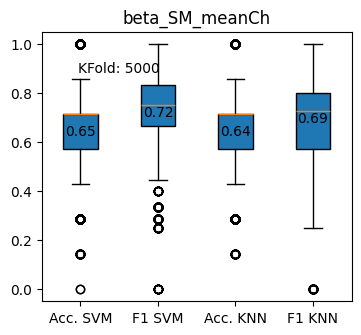

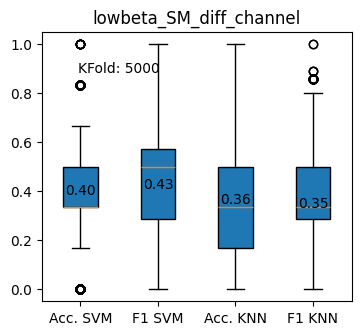

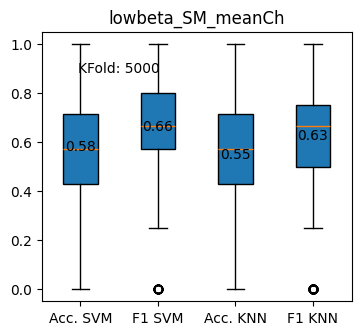

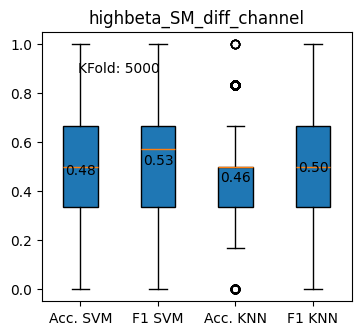

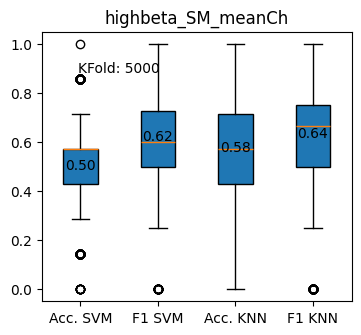

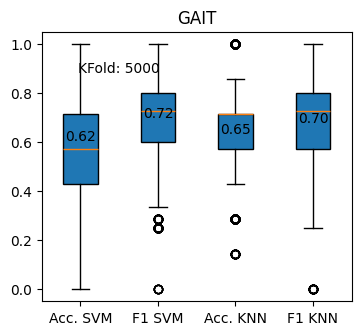

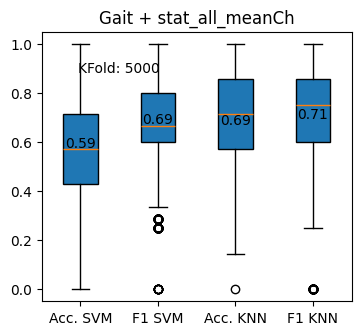

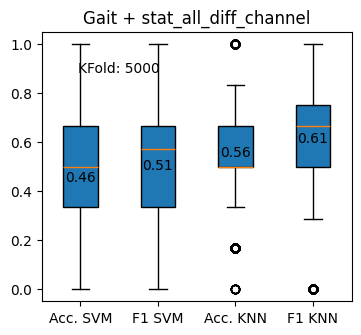

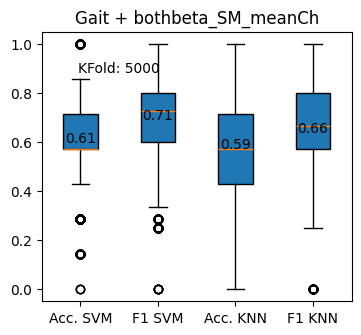

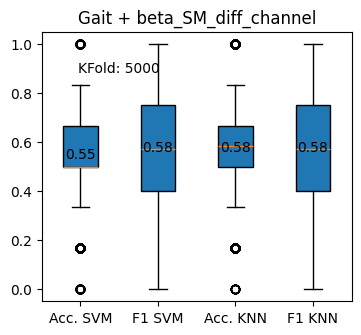

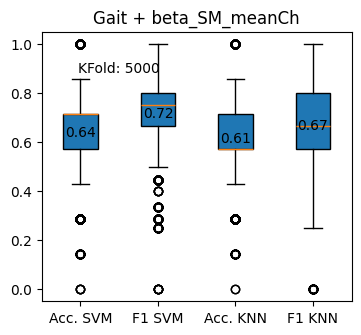

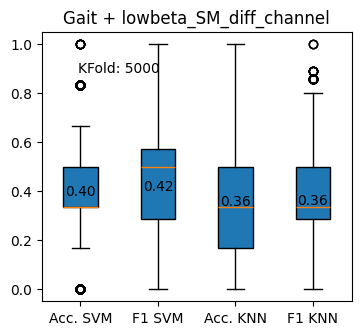

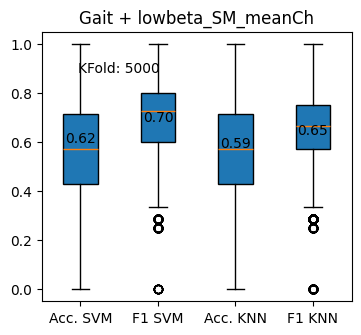

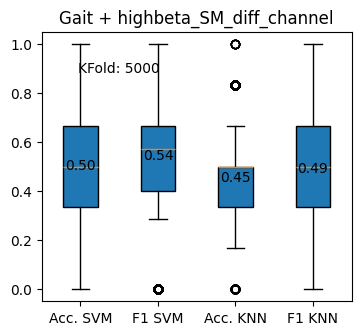

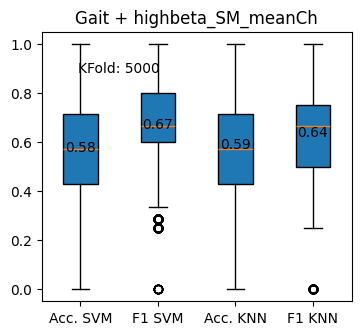

In [ ]:
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_swing1", "t_DA", "t_swing2", "Longueur_pas", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "Cadence", "VZmin_APA", "V2", "Diff_V"]
_,_,_,_ = ClassifIntra(DEj_stat_all_meanCh, columns_to_drop, kfolds=5000, title = "stat_all_meanCh")
_,_,_,_ = ClassifIntra(DEj_stat_all_diff_channel, columns_to_drop, kfolds=5000, title = "stat_all_diff_channel")
_,_,_,_ = ClassifIntra(DEj_bothbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "bothbeta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_beta_SM_diff_channel, columns_to_drop, kfolds=5000, title =  "beta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_beta_SM_meanCh, columns_to_drop, kfolds=5000, title = "beta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_lowbeta_SM_diff_channel, columns_to_drop, kfolds=5000, title = "lowbeta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_lowbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "lowbeta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_highbeta_SM_diff_channel, columns_to_drop, kfolds=5000, title = "highbeta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_highbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "highbeta_SM_meanCh")
columns_to_drop = ["index", "Meta_FOG", "Power"]
_,_,_,_ = ClassifIntra(DEj_stat_all_meanCh, columns_to_drop, kfolds=5000, title = "GAIT")
columns_to_drop = ["index", "Meta_FOG"]
_,_,_,_ = ClassifIntra(DEj_stat_all_meanCh, columns_to_drop, kfolds=5000, title = "Gait + stat_all_meanCh")
_,_,_,_ = ClassifIntra(DEj_stat_all_diff_channel, columns_to_drop, kfolds=5000, title = "Gait + stat_all_diff_channel")
_,_,_,_ = ClassifIntra(DEj_bothbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "Gait + bothbeta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_beta_SM_diff_channel, columns_to_drop, kfolds=5000, title =  "Gait + beta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_beta_SM_meanCh, columns_to_drop, kfolds=5000, title = "Gait + beta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_lowbeta_SM_diff_channel, columns_to_drop, kfolds=5000, title = "Gait + lowbeta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_lowbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "Gait + lowbeta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_highbeta_SM_diff_channel, columns_to_drop, kfolds=5000, title = "Gait + highbeta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_highbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "Gait + highbeta_SM_meanCh")
columns_to_drop = ["index", "Meta_FOG", "t_APA", "APA_antpost", "APA_lateral", "StepWidth", "t_DA", "V_swing1", "Vy_FO1", "Vm", "t_Vm", "VML_absolue", "VZmin_APA", "V2", "Diff_V"]
_,_,_,_ = ClassifIntra(DEj_stat_all_meanCh, columns_to_drop, kfolds=5000, title = "RPC2 + stat_all_meanCh")
_,_,_,_ = ClassifIntra(DEj_stat_all_diff_channel, columns_to_drop, kfolds=5000, title = "RPC2 + stat_all_diff_channel")
_,_,_,_ = ClassifIntra(DEj_bothbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "RPC2 + bothbeta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_beta_SM_diff_channel, columns_to_drop, kfolds=5000, title =  "RPC2 + beta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_beta_SM_meanCh, columns_to_drop, kfolds=5000, title = "RPC2 + beta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_lowbeta_SM_diff_channel, columns_to_drop, kfolds=5000, title = "RPC2 + lowbeta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_lowbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "RPC2 + lowbeta_SM_meanCh")
_,_,_,_ = ClassifIntra(DEj_highbeta_SM_diff_channel, columns_to_drop, kfolds=5000, title = "RPC2 + highbeta_SM_diff_channel")
_,_,_,_ = ClassifIntra(DEj_highbeta_SM_meanCh, columns_to_drop, kfolds=5000, title = "RPC2 + highbeta_SM_meanCh")


# Auto ML

In [ ]:
import autosklearn.classification

def AutoClassifMulti(dataframeTrain,dataframeTest, columns_to_drop, PatientRef, DropMissing=True, Verbose=True):
    if platform.system() == "Windows" :
        print("Windows isn't supported for AutoML")
        return 0, 0
    dataframeTest  = dataframeTest[~dataframeTest["index"].str.contains(PatientRef)]
    if DropMissing :
        dataframeTest  = dataframeTest.dropna(axis=0)
        dataframeTrain = dataframeTrain.dropna(axis=0)
    y_train, X_train = dataframeTrain["Meta_FOG"], dataframeTrain.drop(columns=columns_to_drop).to_numpy()
    y_test,  X_test  = dataframeTest["Meta_FOG"],  dataframeTest.drop(columns=columns_to_drop).to_numpy()

    cls = autosklearn.classification.AutoSklearnClassifier(n_jobs=16).fit(X_train, y_train)
    Accuracy = (accuracy_score(y_test, cls.predict(X_test)))
    F1 = (f1_score(y_test, cls.predict(X_test), pos_label="2"))
    if Verbose :
        print("Accuracy :", f"{Accuracy:.2f}", "- F1 :", f"{F1:.2f}")
        print(cls.sprint_statistics())
        print(" ")
        print(cls.show_models())
        print(" ")
        print(cls.cv_results_)
        print(" ")
        print(cls.leaderboard())
        disp = ConfusionMatrixDisplay.from_estimator(cls, X_test, y_test, display_labels=['NoFOG','FOG'], cmap=plt.cm.Blues, normalize='all', colorbar=False).figure_.set_figwidth(1.5)
        
    return Accuracy, F1

